This is the second simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using curved tracks, 8 detector layers. This is the same as v1, but with smaller sigma (Gaussian uncertainty).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

### Tracker toy model

Muon decaying at (x=0,z), producing positron with momentum (px,pz). 8 layers at given z (infinite in x) that will return x position (Gaussian). $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$v_x = A\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$v_z = A\cos(\frac{qB}{\gamma m} t + \phi)$

$|v|^2 = v_x^2 + v_z^2 = A^2$<br/>
$p_x = |p|\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$p_z = |p|\cos(\frac{qB}{\gamma m} t + \phi)$

$\tan \phi = \frac{v_x(0)}{v_z(0)} = \frac{p_x(0)}{p_z(0)}$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T + \phi) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T + \phi) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|}) - \phi)$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi$ (from the z-axis):<br/>
$x = \frac{p\cos(\phi)}{qB} - \frac{1}{qB}\sqrt{p^2\cos^2(\phi) - q^2B^2z^2 -2qBzp\sin(\phi)}$

In [2]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45
N_det = 8
det_zs = np.linspace(0,(N_det-1)*0.12,N_det) #z-layers

def calc_x(z,p,phi):
    # p is in GeV -> *1e9/c
    p *= 1e9/c
    
    sq = p**2*np.cos(phi)**2 - B**2*z**2 - 2*B*z*p*np.sin(phi)
    sq = np.sqrt(sq)

    return (p*np.cos(phi) - sq)/B

#x position is normal distribution
x_hit = lambda x,sigma: stats.norm(loc=x, scale=sigma)

#example event
z_toy = -9.4e-2
p_toy = 2.4
phi_toy = 0.25

#for Gaussian
sigma = 3e-4

[0.01968015 0.05590199 0.10726634 0.17619791 0.26686027 0.38709087
 0.55492327 0.84282955]


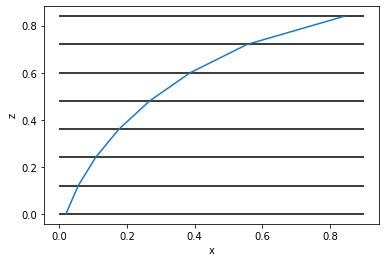

In [3]:
test = calc_x(det_zs+0.1,0.5,0.15)
print(test)
plt.plot(test,det_zs)
plt.hlines(det_zs,0,0.9,color='black')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

In [4]:
def generate_event(z, p, phi):
    # generates an event from given z, p, phi
    # returns length 8 array of measured x-positions
    
    xs = np.empty(N_det)
    dist = det_zs-z
    x_exp = calc_x(dist,p,phi)
    for i in range(N_det):
        if np.isnan(x_exp[i]): pass #need to handle this later, set to -1?
        xs[i] = x_hit(x_exp[i],sigma).rvs()
    return xs

#toy MC
def MC_events(N_events, zlims=(-0.5, -0.0001), plims=(1.5,3), phi_lims=(0,np.pi/8)):
    '''
    sample source parameters from uniform distribution of x, p, and phi (isn't really uniform)
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array z,p,phi
    # p is in GeV -> *1e9/c
    
    z = np.random.uniform(*zlims, N_events)
    p = np.random.uniform(*plims, N_events)
    phi = np.random.uniform(*phi_lims, N_events)

    truth = np.vstack([z, p, phi]).T

    events = []

    for i in range(N_events):
        events.append(generate_event(z[i], p[i], phi[i]))

    return events, truth

In [5]:
def plot_event(x_meas,z,p,phi):
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_title('hit locations')
    ax.set_xlabel('x')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    x_exp = calc_x(det_zs-z,p,phi)
    for i, z_det in enumerate(det_zs):
        #expectation
        x_dist = x_hit(x_exp[i],sigma)
        mu = x_dist.mean()
        std = x_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, x_dist.pdf(times),label=f'z={100*det_zs[i]:.0f} cm')
        
        #measured
        ax.bar(x_meas[i], 50, width=0.003, alpha=0.5,
                  color=color_cycle[i % len(color_cycle)])

    ax.set_yticklabels([])
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

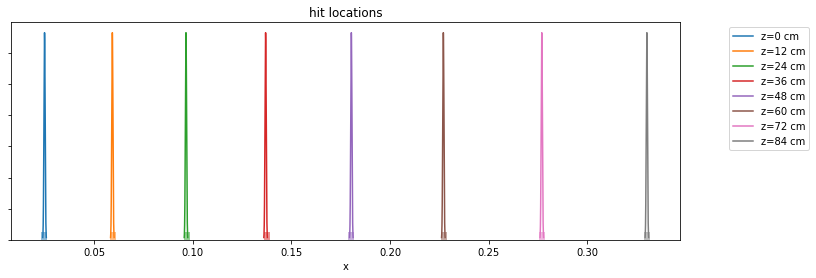

In [6]:
ev = generate_event(z_toy,p_toy,phi_toy)
plot_event(ev,z_toy,p_toy,phi_toy)

$L = \Pi_{i=1}^8 \frac{1}{\sqrt{2\pi}\sigma} \exp(-\frac{(x_{meas}-x_{exp})^2}{2\sigma^2})$<br/>
$\log(L) = \sum_{i=1}^8 -\frac{(x_{meas}-x_{exp})^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma)$

In [7]:
#log-likelihoods

def hit_pdf(x_meas,z,p,phi):
    xs = calc_x(det_zs-z,p,phi)
    
    llh = 0
   
    for i,hit in enumerate(x_meas):
        llh -= (hit-xs[i])**2/(2*sigma**2) + np.log(sigma)
    
    #store negative LLH, multiply by -1
    return -llh

In [8]:
grid_spacing = 100

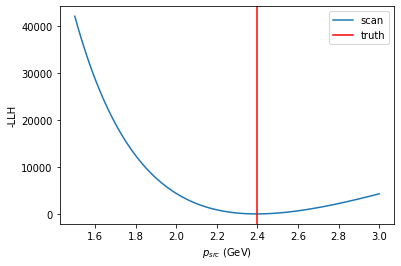

In [9]:
#full range
ps = np.linspace(1.5,3,grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 1, ps, [z_toy, p_toy, phi_toy])

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

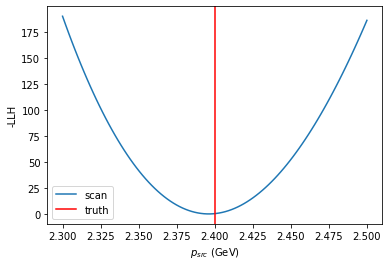

In [10]:
#zoomed in to smaller llhs
ps = np.linspace(2.3,2.5,grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 1, ps, [z_toy, p_toy, phi_toy])

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

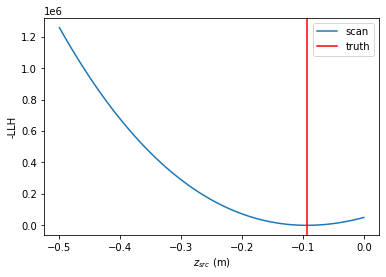

In [11]:
#full range
zs = np.linspace(-0.5,-0.001,grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, [z_toy, p_toy, phi_toy])

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

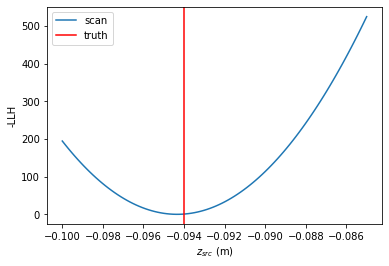

In [12]:
#zoomed in
zs = np.linspace(-0.1,-0.085,grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, [z_toy, p_toy, phi_toy])

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

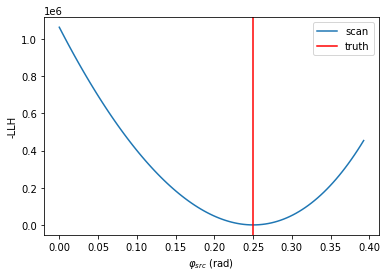

In [13]:
#full range
phis = np.linspace(0, np.pi/8, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, [z_toy, p_toy, phi_toy])

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

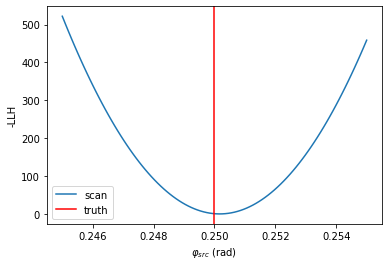

In [14]:
#zoomed in
phis = np.linspace(0.245, 0.255, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, [z_toy, p_toy, phi_toy])

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

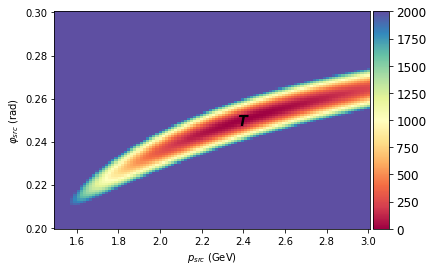

In [15]:
#larger range
ps = np.linspace(1.5,3,grid_spacing)
phis = np.linspace(0.2, 0.3, grid_spacing)

llh_p_phi_scan = map_2d(hit_pdf, ev, (1, 2), (ps, phis), [z_toy,p_toy,phi_toy])

plot_2d_scan(llh_p_phi_scan, ps, phis, p_toy, phi_toy,
                   axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=2000,log=False)

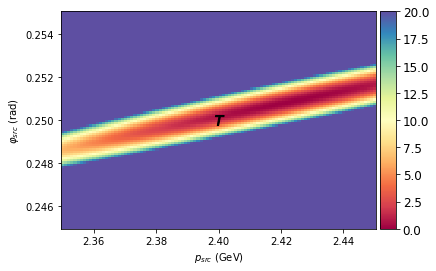

In [16]:
#zoomed in
ps = np.linspace(2.35,2.45,grid_spacing)
phis = np.linspace(0.245, 0.255, grid_spacing)

llh_p_phi_scan = map_2d(hit_pdf, ev, (1, 2), (ps, phis), [z_toy,p_toy,phi_toy])

plot_2d_scan(llh_p_phi_scan, ps, phis, p_toy, phi_toy,
                   axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=20,log=False)

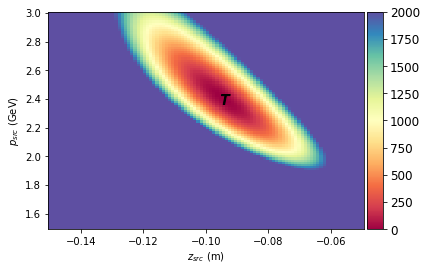

In [17]:
#larger range
ps = np.linspace(1.5,3,grid_spacing)
zs = np.linspace(-0.15,-0.05,grid_spacing)

llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), [z_toy,p_toy,phi_toy])

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],vmax=2000,log=False)

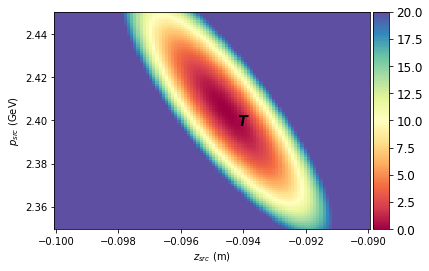

In [18]:
#zoomed in
ps = np.linspace(2.35,2.45,grid_spacing)
zs = np.linspace(-0.1,-0.09,grid_spacing)

llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), [z_toy,p_toy,phi_toy])

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],vmax=20,log=False)

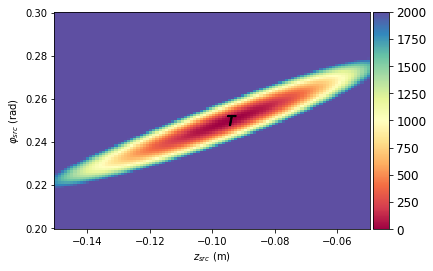

In [19]:
#larger range
zs = np.linspace(-0.15,-0.05,grid_spacing)
phis = np.linspace(0.2, 0.3, grid_spacing)

llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), [z_toy,p_toy,phi_toy])

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=2000,log=False)

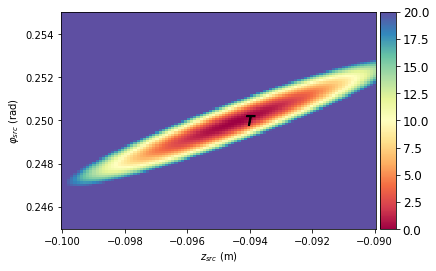

In [20]:
#zoomed in
zs = np.linspace(-0.1,-0.09,grid_spacing)
phis = np.linspace(0.245, 0.255, grid_spacing)

llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), [z_toy,p_toy,phi_toy])

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=20,log=False)

In [21]:
N_mc = 100000
mc, truth = MC_events(N_mc, zlims=(-0.11, -0.08), plims=(2.2,2.6), phi_lims=(0.23,0.27))

In [22]:
#neural net

hitnet = types.SimpleNamespace() 

hitnet.events = mc

hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.vstack((hitnet.events,np.tile(det_zs,N_mc))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

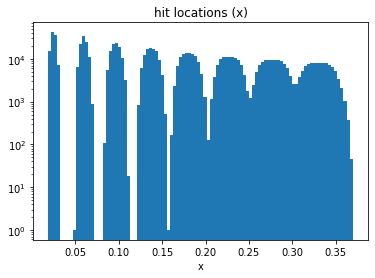

In [23]:
#histogram of hit positions (x)
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [24]:
#need trafo to combine measurements and (hypothetical) input params into input for NN
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        #d = hits[:,1]-theta[:,0]
        #px = theta[:,1]*tf.math.sin(theta[:,2])
        #pz = theta[:,1]*tf.math.cos(theta[:,2])
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 #d,
                 #px,
                 #pz,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
        return out
    
hitnet.trafo = trafo

In [25]:
#make training and test datasets
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)


#hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=5)

In [26]:
## Neural Net

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 5)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         trafo[0][0]                  

In [27]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [36]:
#training

#n_epochs = 5
#for i in range(n_epochs):
#    hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
#    hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)
#    hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=1, verbose=1, validation_data=hitnet.d_test)

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=30, verbose=1, validation_data=hitnet.d_test)

Epoch 1/25
313/313 [==============================] - 20s 64ms/step - loss: 0.3712 - val_loss: 0.4708
Epoch 2/25
313/313 [==============================] - 19s 62ms/step - loss: 0.3860 - val_loss: 0.2444
Epoch 3/25
313/313 [==============================] - 19s 60ms/step - loss: 0.3985 - val_loss: 0.2352
Epoch 4/25
313/313 [==============================] - 19s 61ms/step - loss: 0.4314 - val_loss: 0.3596
Epoch 5/25
313/313 [==============================] - 19s 60ms/step - loss: 0.3522 - val_loss: 0.3226
Epoch 6/25
313/313 [==============================] - 19s 61ms/step - loss: 0.3928 - val_loss: 0.2256
Epoch 7/25
313/313 [==============================] - 19s 61ms/step - loss: 0.3601 - val_loss: 0.2957
Epoch 8/25
313/313 [==============================] - 20s 65ms/step - loss: 0.3485 - val_loss: 0.3543
Epoch 9/25
313/313 [==============================] - 22s 69ms/step - loss: 0.3424 - val_loss: 0.5718
Epoch 10/25
313/313 [==============================] - 21s 69ms/step - loss: 0.397

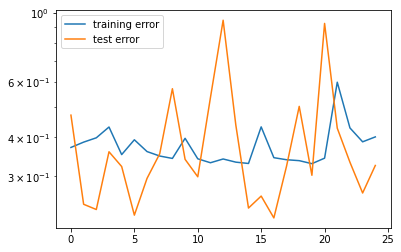

In [37]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear #result is log r(x,theta)
hitnet.llh.compile()

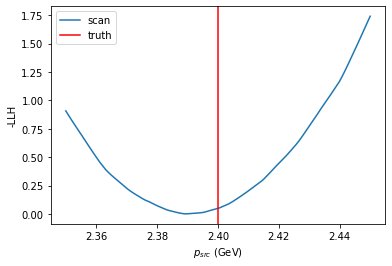

In [38]:
#neural net scan
ps = np.linspace(2.35,2.45,100)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,ps,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

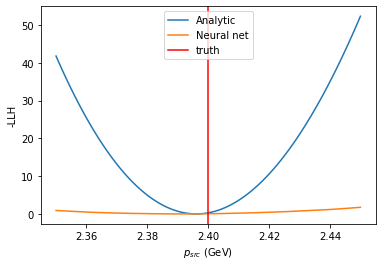

In [39]:
#comparison NN and analytical
llh_p_scan = map_1d(hit_pdf, ev, 1, ps, [z_toy, p_toy, phi_toy])

plot_1d_diff(llh_p_scan, nn_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

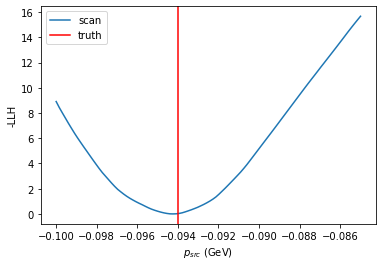

In [40]:
#neural net scan
zs = np.linspace(-0.1,-0.085,100)

scan_t = np.vstack([zs,np.ones(grid_spacing)*p_toy,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$p_{src}$ (GeV)')

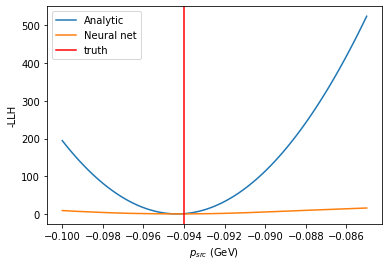

In [41]:
#comparison NN and analytical
llh_z_scan = map_1d(hit_pdf, ev, 0, zs, [z_toy, p_toy, phi_toy])

plot_1d_diff(llh_z_scan, nn_z_scan, zs, z_toy, '$p_{src}$ (GeV)')

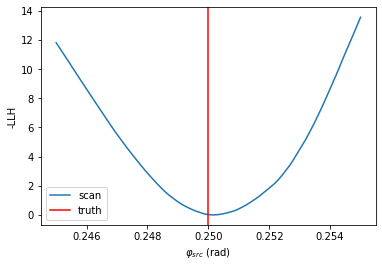

In [42]:
#neural net scan
phis = np.linspace(0.245, 0.255, grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy,phis]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_phi_scan = hitnet.llh.predict([scan_x,scan_t])

nn_phi_scan = -np.sum(nn_phi_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_phi_scan, phis, phi_toy, axis_label=r'$\varphi_{src}$ (rad)')

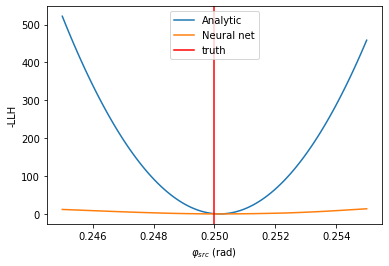

In [43]:
#comparison NN and analytical
llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, [z_toy, p_toy, phi_toy])

plot_1d_diff(llh_phi_scan, nn_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

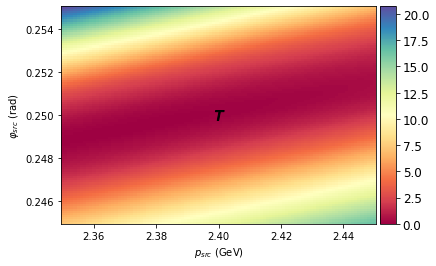

In [44]:
#neural net scan
mg = np.meshgrid(ps,phis)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*z_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_p_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_p_phi_scan, ps, phis, p_toy, phi_toy, 
            axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'])

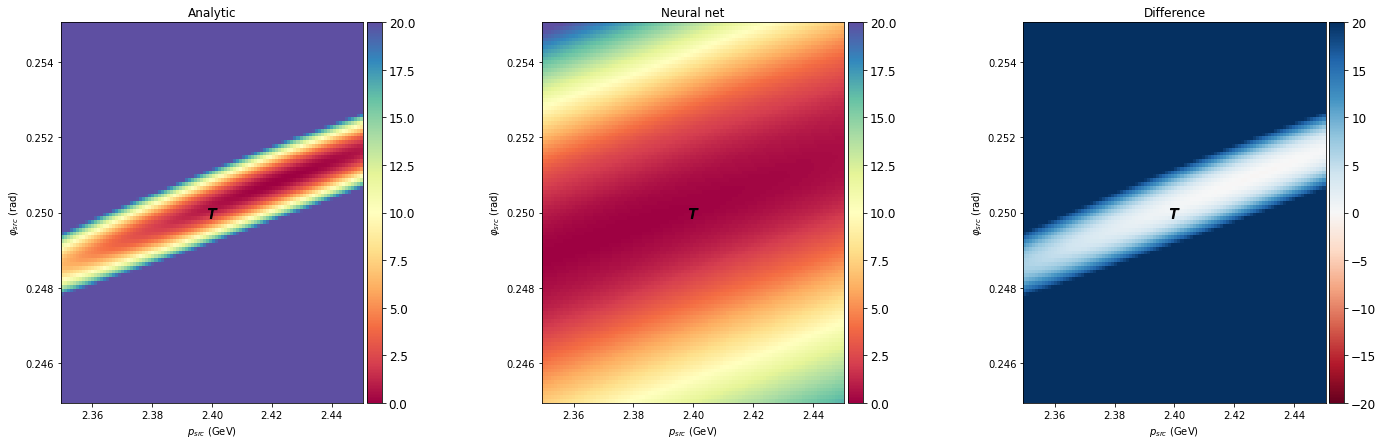

In [45]:
#comparison
llh_p_phi_scan = map_2d(hit_pdf, ev, (1,2), (ps,phis), [z_toy,p_toy,phi_toy])

plot_2d_diff(llh_p_phi_scan, NN_p_phi_scan, ps, phis, p_toy, phi_toy,
             axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'], vmax=20, vmax_d=20)

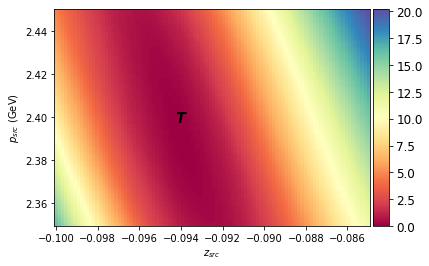

In [46]:
#neural net scan
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*phi_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'])

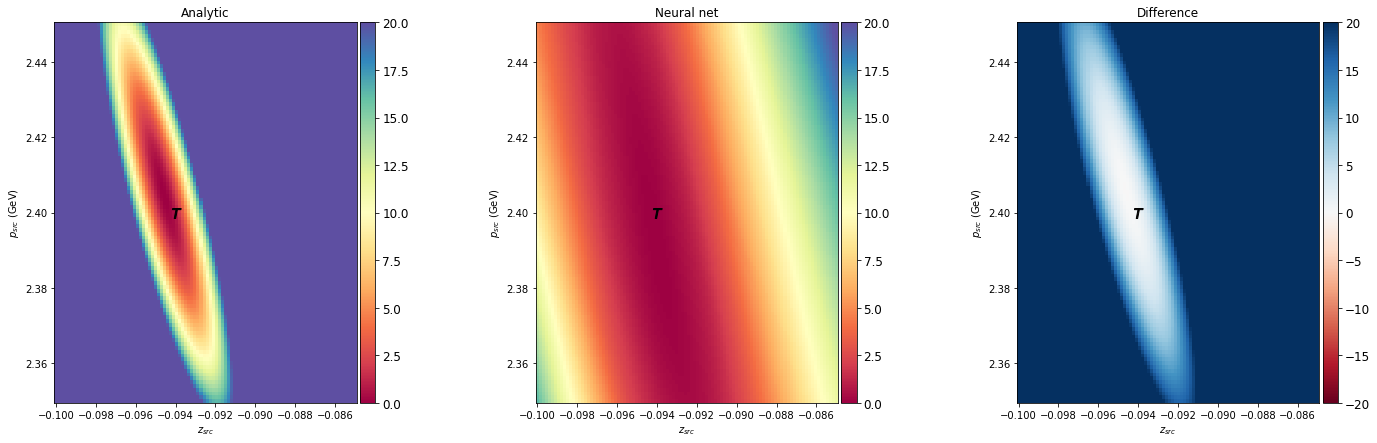

In [47]:
#comparison
llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), [z_toy,p_toy,phi_toy])

plot_2d_diff(llh_z_p_scan, NN_z_p_scan, zs, ps, z_toy, p_toy,
             axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'], vmax=20, vmax_d=20)

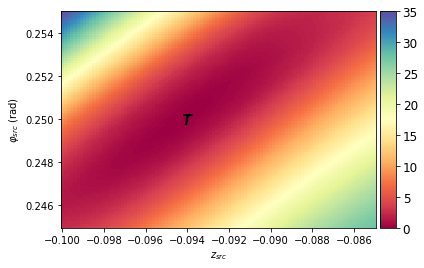

In [48]:
#neural net scan
mg = np.meshgrid(zs,phis)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*p_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_phi_scan, zs, phis, z_toy, phi_toy, 
            axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'])

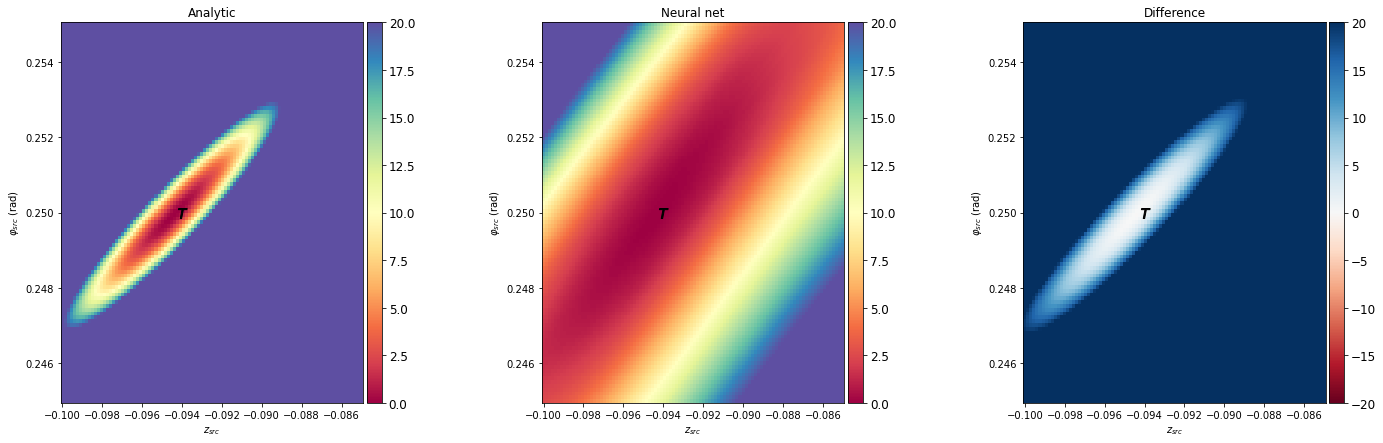

In [49]:
#comparison
llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), [z_toy,p_toy,phi_toy])

plot_2d_diff(llh_z_phi_scan, NN_z_phi_scan, zs, phis, z_toy, phi_toy,
             axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'], vmax=20, vmax_d=20)

In [50]:
#minimize analytic likelihood
def ana_llh(theta,event):
    #wrapper funtion
    return hit_pdf(event,*theta)

print(z_toy,p_toy,phi_toy)
print(ana_llh([z_toy,p_toy,phi_toy],ev))

-0.094 2.4 0.25
-61.26803755047117


In [51]:
#run a bound minimizer
opt_params = minimize(ana_llh,[-0.5,2.0,0],args=(ev),method='Powell',bounds=[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],options={'maxiter':100000,'disp':True,'return_all':False})

print(opt_params)
#relative error
print("\nerrors:")
print("z (mm):",1000*(opt_params.x[0]-z_toy))
print("p (MeV):",1000*(opt_params.x[1]-p_toy))
print("phi (rad):",(opt_params.x[2]-phi_toy))
print("relative error (%):")
print(100*(opt_params.x - [z_toy,p_toy,phi_toy])/[z_toy,p_toy,phi_toy])

Optimization terminated successfully.
         Current function value: -62.729228
         Iterations: 17
         Function evaluations: 703
   direc: array([[1.26372773e-04, 3.86324514e-02, 1.13093856e-03],
       [1.17296666e-02, 2.35884082e-01, 1.79855122e-02],
       [1.60358020e-04, 2.98332367e-03, 1.64651980e-04]])
     fun: -62.72922781325043
 message: 'Optimization terminated successfully.'
    nfev: 703
     nit: 17
  status: 0
 success: True
       x: array([-0.09301524,  2.44415585,  0.25198546])

errors:
z (mm): 0.9847601726071242
p (MeV): 44.15584569813635
phi (rad): 0.0019854612729014454
relative error (%):
[-1.0476172   1.8398269   0.79418451]


In [52]:
#minimize nn output
def nn_llh(theta, event):
    #wrapper function
    
    #reshape events into 8x2 array 
    event = np.vstack((event,det_zs)).T

    #repeat truth for each hit in event
    theta = np.array(theta)
    theta = np.repeat(theta[np.newaxis,:], N_det, axis=0)

    #let neural net predict llh for each event, sum is total llh
    pred = hitnet.llh.predict([event,theta])
    return -1*pred.sum()

print(z_toy,p_toy,phi_toy)
print(nn_llh([z_toy,p_toy,phi_toy],ev))

-0.094 2.4 0.25
-12.185711860656738


In [53]:
#run a bound minimizer - within training ranges
opt_params = minimize(nn_llh,[-0.11,2.2,0.23],args=(ev),method='Powell',bounds=[(-0.11,-0.08),(2.2,2.6),(0.23,0.27)],options={'maxiter':100000,'disp':True,'return_all':False})

print(opt_params)
#relative error
print("\nerrors:")
print("z (mm):",1000*(opt_params.x[0]-z_toy))
print("p (MeV):",1000*(opt_params.x[1]-p_toy))
print("phi (rad):",(opt_params.x[2]-phi_toy))
print("relative error (%):")
print(100*(opt_params.x - [z_toy,p_toy,phi_toy])/[z_toy,p_toy,phi_toy])

Optimization terminated successfully.
         Current function value: -12.328877
         Iterations: 10
         Function evaluations: 635
   direc: array([[3.20617240e-03, 4.97683926e-05, 2.22466083e-03],
       [3.00402672e-05, 1.96579430e-04, 8.86412655e-05],
       [9.57790325e-04, 8.52486330e-02, 2.70590133e-03]])
     fun: -12.328877449035645
 message: 'Optimization terminated successfully.'
    nfev: 635
     nit: 10
  status: 0
 success: True
       x: array([-0.09706299,  2.29324964,  0.24508024])

errors:
z (mm): -3.062986578334301
p (MeV): -106.75035517079623
phi (rad): -0.004919755588760344
relative error (%):
[ 3.25849636 -4.44793147 -1.96790224]


In [54]:
#test again with different starting guesses
opt_params = minimize(nn_llh,[-0.08,2.6,0.27],args=(ev),method='Powell',bounds=[(-0.11,-0.08),(2.2,2.6),(0.23,0.27)],options={'maxiter':100000,'disp':True,'return_all':False})

print(opt_params)
#relative error
print("\nerrors:")
print("z (mm):",1000*(opt_params.x[0]-z_toy))
print("p (MeV):",1000*(opt_params.x[1]-p_toy))
print("phi (rad):",(opt_params.x[2]-phi_toy))
print("relative error (%):")
print(100*(opt_params.x - [z_toy,p_toy,phi_toy])/[z_toy,p_toy,phi_toy])

Optimization terminated successfully.
         Current function value: -12.340967
         Iterations: 12
         Function evaluations: 895
   direc: array([[-7.45956838e-04, -1.57385927e-02, -8.00158902e-04],
       [-5.41597495e-04, -2.24984133e-02, -9.50780127e-04],
       [ 1.86477930e-05,  2.22442815e-04,  1.90716896e-05]])
     fun: -12.340967178344727
 message: 'Optimization terminated successfully.'
    nfev: 895
     nit: 12
  status: 0
 success: True
       x: array([-0.09482665,  2.36191301,  0.24861786])

errors:
z (mm): -0.8266508152562912
p (MeV): -38.0869896292495
phi (rad): -0.0013821374631614591
relative error (%):
[ 0.87941576 -1.5869579  -0.55285499]


In [55]:
#run a bound minimizer - full range same as analytical
opt_params = minimize(nn_llh,[-0.5,2.0,0],args=(ev),method='Powell',bounds=[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],options={'maxiter':100000,'disp':True,'return_all':False})

print(opt_params)
#relative error
print("\nerrors:")
print("z (mm):",1000*(opt_params.x[0]-z_toy))
print("p (MeV):",1000*(opt_params.x[1]-p_toy))
print("phi (rad):",(opt_params.x[2]-phi_toy))
print("relative error (%):")
print(100*(opt_params.x - [z_toy,p_toy,phi_toy])/[z_toy,p_toy,phi_toy])

Optimization terminated successfully.
         Current function value: -4.185488
         Iterations: 1
         Function evaluations: 55
   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: -4.185488224029541
 message: 'Optimization terminated successfully.'
    nfev: 55
     nit: 1
  status: 0
 success: True
       x: array([-2.19809638e-01,  1.91985502e+00,  6.44081712e-05])

errors:
z (mm): -125.80963777777902
p (MeV): -480.14497852283756
phi (rad): -0.2499355918288367
relative error (%):
[133.84004019 -20.00604077 -99.97423673]


Performs similarly to larger sigma, but training is harder; depending on starting guess, performance is slightly better.